In [0]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Read flight data
flight_data_1 = spark.read.csv("dbfs:/FileStore/tables/2019_01.csv", header=True, inferSchema=True)
flight_data_2 = spark.read.csv("dbfs:/FileStore/tables/2019_02.csv", header=True, inferSchema=True)
flight_data_3 = spark.read.csv("dbfs:/FileStore/tables/2019_03.csv", header=True, inferSchema=True)

# Combine flight data into a single DataFrame
flight_data = flight_data_1.union(flight_data_2).union(flight_data_3)
flight_data = flight_data.dropDuplicates()
critical_columns = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
flight_data = flight_data.dropna(subset=critical_columns)
flight_data = flight_data.orderBy("MONTH", "DAY_OF_MONTH", "DEP_TIME")

# Filter out cancelled flights
flight_data = flight_data.filter(~(col('CANCELLED') == 1))


# Read additional datasets
airports_data = spark.read.csv("dbfs:/FileStore/tables/airports.csv", header=True, inferSchema=True)
carriers_data = spark.read.csv("dbfs:/FileStore/tables/carriers.csv", header=True, inferSchema=True)
planes_data = spark.read.csv("dbfs:/FileStore/tables/plane_data.csv", header=True, inferSchema=True)


# Replace 'None' string with NULL
planes_data = planes_data.withColumn("year", when(col("year") == "None", None).otherwise(col("year")))
# Cast 'year' column to integer type
planes_data = planes_data.withColumn("year", col("year").cast("int"))

# Show the schema to verify the data
flight_data.printSchema()
airports_data.printSchema()
carriers_data.printSchema()
planes_data.printSchema()

flight_data.cache()

# Show some sample data
flight_data.show(5)
airports_data.show(5)



root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: integer (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: integer (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DI

In [0]:
from pyspark.sql.functions import col, avg, round, count, coalesce, abs, lit, sum

# Calculate average departure and arrival delays for each airport and round to 2 decimal places
avg_dep_delays = flight_data.groupBy("ORIGIN").agg(
    round(avg(col("DEP_DELAY")), 2).alias("avg_dep_delay")
)

avg_arr_delays = flight_data.groupBy("DEST").agg(
    round(avg(col("ARR_DELAY")), 2).alias("avg_arr_delay")
)

# Join with airport data to get airport names for departure and arrival delays
avg_dep_delays = avg_dep_delays.join(airports_data, avg_dep_delays.ORIGIN == airports_data.iata, "left").select(
    col("iata").alias("airport_iata"),"airport","city","state","country","avg_dep_delay"
)

avg_arr_delays = avg_arr_delays.join(airports_data, avg_arr_delays.DEST == airports_data.iata, "left").select(
    col("iata").alias("airport_iata"),
    "avg_arr_delay"
)

# Join avg_dep_delays with avg_arr_delays on airport_iata
avg_delays_combined = avg_dep_delays.join(
    avg_arr_delays,
    "airport_iata",
    "inner"
)

# Calculate total delay by adding departure delay and arrival delay and round to 2 decimal places
avg_delays_combined = avg_delays_combined.withColumn(
    "total_delay",
    round(col("avg_dep_delay") + col("avg_arr_delay"), 2)
)

# Calculate the number of departing and arriving flights for each airport
flight_counts = flight_data.groupBy("ORIGIN").agg(count("*").alias("num_departing_flights")).union(
    flight_data.groupBy("DEST").agg(count("*").alias("num_arriving_flights"))
).groupBy("ORIGIN").agg(sum("num_departing_flights").alias("total_flights"))

# Join the total flights count with avg_delays_combined DataFrame
avg_delays_combined = avg_delays_combined.join(
    flight_counts,
    avg_delays_combined.airport_iata == flight_counts.ORIGIN,
    "left"
).select("airport_iata", "airport", "city", "state", "avg_dep_delay", "avg_arr_delay", "total_delay", "total_flights")

# Show the DataFrame with combined delays
avg_delays_combined=avg_delays_combined.orderBy("total_delay")
avg_delays_combined.show()

import plotly.express as px
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
avg_delays_combined_pd = avg_delays_combined.toPandas()

# Create a bar chart
fig = px.bar(
    avg_delays_combined_pd,
    x='airport',
    y='total_delay',
    title='Overall Delay of All Airports',
    labels={'airport': 'Airport', 'total_delay': 'Total Delay (minutes)'},
    hover_data=['avg_dep_delay', 'avg_arr_delay', 'total_flights']
)

# Update x-axis to remove tick labels but keep the axis label
fig.update_layout(
    xaxis=dict(
        tickvals=[],
        title='Airport'
    )
)

# Show the plot
fig.show()

# Calculate the average total flights per airport
average_total_flights = avg_delays_combined.select(avg(col("total_flights"))).first()[0]

# Filter airports with both avg_arr_delay and avg_dep_delay less than 15 and total flights greater than the average total flights
filtered_avg_delays = avg_delays_combined.filter(
    (abs(col("avg_arr_delay")) < 15) & (abs(col("avg_dep_delay")) < 15) & (col("total_flights") > average_total_flights)
)


# Order by the total delay
filtered_avg_delays = filtered_avg_delays.orderBy(abs(col("total_delay")))
filtered_avg_delays.cache()

# Select the top 20
top_20_airports = filtered_avg_delays.limit(20)

# Show the top 20 airports with delays closest to 0
top_20_airports.show()

# Convert to Pandas for visualization (if needed)
top_20_airports_pd = top_20_airports.toPandas()


import plotly.express as px

# Create the horizontal bar chart using Plotly
fig = px.bar(
    top_20_airports_pd,
    x='total_delay',
    y='airport',
    orientation='h',
    title='Top 20 Airports with Delays Nearest to 0 Minutes',
    labels={'total_delay': 'Average Total Delay (minutes)', 'airport': 'Airport'},
    color='total_delay',
    color_continuous_scale='blues'  # Change color scale to 'blues'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Average Total Delay (minutes)',
    yaxis_title='Airport',
    yaxis=dict(categoryorder='total descending'),
    height=600,  # Adjust the height of the figure to accommodate all labels
    font=dict(size=11)  # Adjust font size for better readability
)

# Show the plot
fig.show()

+------------+--------------------+------------+-----+-------------+-------------+-----------+-------------+
|airport_iata|             airport|        city|state|avg_dep_delay|avg_arr_delay|total_delay|total_flights|
+------------+--------------------+------------+-----+-------------+-------------+-----------+-------------+
|         BRW|Wiley Post Will R...|      Barrow|   AK|       -10.36|       -10.66|     -21.02|          347|
|         SCC|           Deadhorse|   Deadhorse|   AK|        -9.08|        -7.44|     -16.52|          480|
|         PAE|   Snohomish County |     Everett|   WA|         -1.5|        -14.5|      -16.0|           10|
|         ADK|                Adak|        Adak|   AK|          6.0|        -21.0|      -15.0|           46|
|         LWS|Lewiston-Nez Perc...|    Lewiston|   ID|        -3.72|        -9.91|     -13.63|          397|
|         OME|                Nome|        Nome|   AK|        -8.73|        -3.89|     -12.62|          325|
|         CPR| Natr

+------------+--------------------+-------------+-----+-------------+-------------+-----------+-------------+
|airport_iata|             airport|         city|state|avg_dep_delay|avg_arr_delay|total_delay|total_flights|
+------------+--------------------+-------------+-----+-------------+-------------+-----------+-------------+
|         PHL|   Philadelphia Intl| Philadelphia|   PA|         6.44|        -0.41|       6.03|        53078|
|         PDX|       Portland Intl|     Portland|   OR|         5.74|         1.13|       6.87|        27451|
|         HNL|Honolulu Internat...|     Honolulu|   HI|         4.11|         2.89|        7.0|        23124|
|         ATL|William B Hartsfi...|      Atlanta|   GA|         7.79|        -0.04|       7.75|       185237|
|         SAT|San Antonio Inter...|  San Antonio|   TX|         5.88|         2.51|       8.39|        19270|
|         SJC|San Jose Internat...|     San Jose|   CA|         6.35|         2.11|       8.46|        27968|
|         

+----+--------------------+--------------+-----+---------------+---------------+--------------+----------------+---------------+
|iata|             airport|          city|state|on_time_arr_pct|on_time_dep_pct|total_arrivals|total_departures|avg_on_time_pct|
+----+--------------------+--------------+-----+---------------+---------------+--------------+----------------+---------------+
| HNL|Honolulu Internat...|      Honolulu|   HI|          82.91|          89.49|         11562|           11562|           86.2|
| ATL|William B Hartsfi...|       Atlanta|   GA|          86.77|          85.06|         92585|           92652|         85.915|
| OGG|             Kahului|       Kahului|   HI|          84.69|          86.96|          6139|            6128|         85.825|
| PHL|   Philadelphia Intl|  Philadelphia|   PA|          85.41|          86.14|         26525|           26553|         85.775|
| IAD|Washington Dulles...|     Chantilly|   VA|          84.53|          86.19|         15234|  

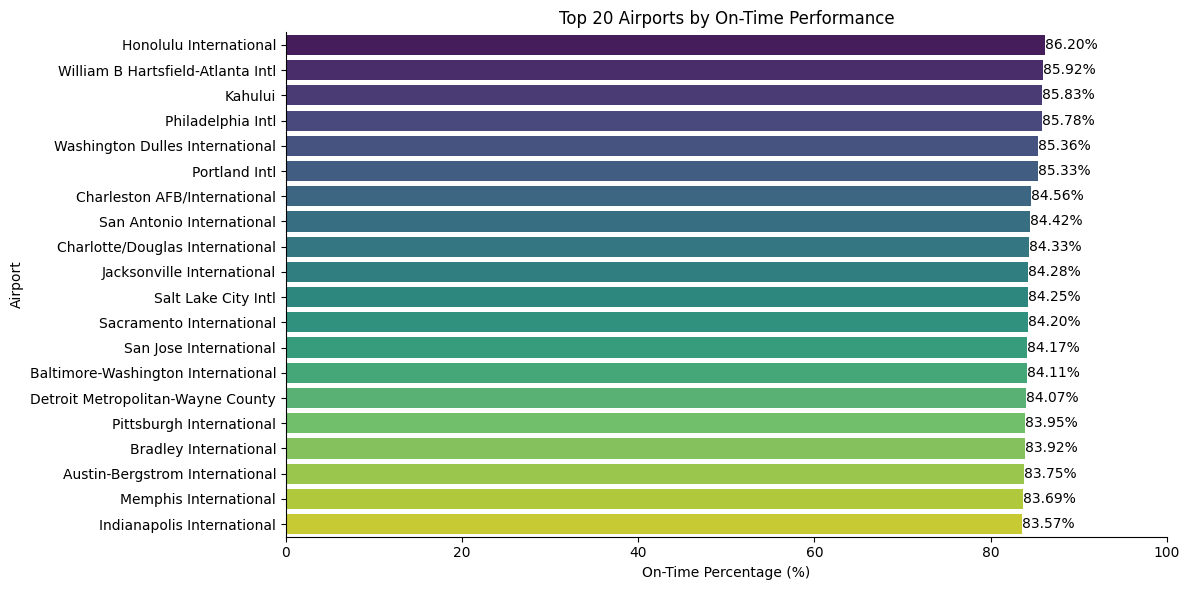

In [0]:
from pyspark.sql.functions import round, count, col, avg, desc


# Calculate the percentage of on-time arrivals (ARR_DELAY <= 15 minutes) for each destination airport
on_time_arrivals = (
    flight_data.filter(col("ARR_DELAY") <= 15)
    .groupBy("DEST")
    .agg(count("*").alias("on_time_arrivals"))
)

total_arrivals = flight_data.groupBy("DEST").agg(count("*").alias("total_arrivals"))

arrival_stats = (
    on_time_arrivals.join(total_arrivals, on="DEST", how="inner")
    .withColumn("on_time_arr_pct", round(col("on_time_arrivals") / col("total_arrivals") * 100, 2))
)

# Calculate the percentage of on-time departures (DEP_DELAY <= 15 minutes) for each origin airport
on_time_departures = (
    flight_data.filter(col("DEP_DELAY") <= 15)
    .groupBy("ORIGIN")
    .agg(count("*").alias("on_time_departures"))
)

total_departures = flight_data.groupBy("ORIGIN").agg(count("*").alias("total_departures"))

departure_stats = (
    on_time_departures.join(total_departures, on="ORIGIN", how="inner")
    .withColumn("on_time_dep_pct", round(col("on_time_departures") / col("total_departures") * 100, 2))
)

# Combine arrival and departure statistics
airport_stats = (
    arrival_stats.join(departure_stats, arrival_stats["DEST"] == departure_stats["ORIGIN"], "inner")
    .select(
        arrival_stats["DEST"].alias("iata"),
        "on_time_arr_pct",
        "on_time_dep_pct",
        "total_arrivals",
        "total_departures"
    )
)

# Optionally, join with airport data to include airport names
airport_stats = airport_stats.join(
    airports_data, airport_stats.iata == airports_data.iata, "left"
).select(
    airport_stats["iata"].alias("iata"),
    "airport",
    "city",
    "state",
    "on_time_arr_pct",
    "on_time_dep_pct",
    "total_arrivals",
    "total_departures"
)

# Calculate the average total number of flights (arrivals + departures) across all airports
avg_total_flights = airport_stats.select(avg(col("total_arrivals") + col("total_departures"))).first()[0]

# Filter the DataFrame to include only records with total flights (arrivals + departures) above the average
airport_stats = airport_stats.filter((col("total_arrivals") + col("total_departures")) > avg_total_flights)

# Order by on-time arrival percentage and on-time departure percentage in descending order
airport_stats=airport_stats.withColumn("avg_on_time_pct",round((col("on_time_arr_pct") + col("on_time_dep_pct")),2)/2)

airport_stats = airport_stats.orderBy(col("avg_on_time_pct").desc())

# Display the result
airport_stats.show()
airport_stats.cache()

# Convert the DataFrame to a Pandas DataFrame
airport_stats_pandas = airport_stats.toPandas()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Filter the top 20 airports by on_time_pct
top_20_airports = airport_stats_pandas.nlargest(20, 'avg_on_time_pct')

# Set the figure size
plt.figure(figsize=(12, 6))

# Create the bar plot using seaborn
sns.barplot(
    x='avg_on_time_pct', 
    y='airport', 
    data=top_20_airports, 
    palette='viridis'
)

# Add titles and labels
plt.title('Top 20 Airports by On-Time Performance')
plt.xlabel('On-Time Percentage (%)')
plt.ylabel('Airport')

# Display the percentage values on the bars
for index, value in enumerate(top_20_airports['avg_on_time_pct']):
    plt.text(value, index, f'{value:.2f}%', va='center', ha='left')

# Enhance the aesthetics
sns.despine()
plt.xlim(0, 100)  # Assuming percentages are between 0 and 100

# Show the plot
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import avg, round, sum, col, count

# Calculate average security delay, NAS delay, and counts for each destination airport where delays are greater than 0
NAS_delay_airport = flight_data.groupBy("DEST").agg(
    sum((col("SECURITY_DELAY") > 0).cast("int")).alias("SECURITY_DELAY_COUNT"),
    sum((col("NAS_DELAY") > 0).cast("int")).alias("NAS_DELAY_COUNT"),
    count("*").alias("TOTAL_FLIGHTS")
)

# Calculate the ratio of Security delay counts to total number of flights
NAS_delay_airport = NAS_delay_airport.withColumn(
    "SECURITY_DELAY_RATIO", round(col("SECURITY_DELAY_COUNT") / col("TOTAL_FLIGHTS"), 4)
)

# Calculate the ratio of NAS delay counts to total number of flights
NAS_delay_airport = NAS_delay_airport.withColumn(
    "NAS_DELAY_RATIO", round(col("NAS_DELAY_COUNT") / col("TOTAL_FLIGHTS"), 3)
)


# Calculate the average total flights per airport
avg_total_flights = NAS_delay_airport.select(
    (sum("TOTAL_FLIGHTS") / count("DEST")).alias("avg_total_flights")
).first()["avg_total_flights"]

# Filter out airports with total flights more than the average total flights per airport
filtered_NAS_delay_airport = NAS_delay_airport.filter(
    col("TOTAL_FLIGHTS") > avg_total_flights
)


filtered_NAS_delay_airport  = filtered_NAS_delay_airport.orderBy("NAS_DELAY_RATIO")

# Join with airport data to get airport names
filtered_NAS_delay_airport = filtered_NAS_delay_airport.join(airports_data, 
filtered_NAS_delay_airport.DEST == airports_data.iata, "left").select(
    "iata", 
    "airport", 
    "city",
    "SECURITY_DELAY_RATIO", 
    "NAS_DELAY_RATIO",  
    "TOTAL_FLIGHTS"
)

# Show the DataFrame with airport names
filtered_NAS_delay_airport=filtered_NAS_delay_airport.orderBy("NAS_DELAY_RATIO")
display(filtered_NAS_delay_airport)
filtered_NAS_delay_airport.cache()


# Create a bar chart for NAS Delay Ratio
fig_nas = px.bar(
    filtered_NAS_delay_airport.toPandas(),
    y='NAS_DELAY_RATIO',
    x='iata',
    title='NAS Delay Ratio for Each Airport',
    labels={'iata': 'Airport', 'NAS_DELAY_RATIO': 'NAS Delay Ratio'},
    hover_data={'iata': False, 'airport': True, 'NAS_DELAY_RATIO': True},
    orientation='v',
    color_discrete_sequence=['blue']
)

# Show the plot for NAS Delay Ratio
fig_nas.show()

# Sort the data by NAS Delay Ratio
sorted_nas_data = filtered_NAS_delay_airport.toPandas().sort_values(by='NAS_DELAY_RATIO', ascending=False)

# only NAS plots as Security delays are insignificant in comparison
import plotly.graph_objects as go
import pandas as pd

# Take the top 10 and bottom 10
bottom10_nas = sorted_nas_data.head(10)
top10_nas = sorted_nas_data.tail(10)

# Combine top 10 and bottom 10
combined_nas = pd.concat([bottom10_nas, top10_nas])

# Create a new column to distinguish top 10 and bottom 10
combined_nas['category'] = ['Bottom 10'] * 10 + ['Top 10'] * 10

# Plot the combined data
fig_combined_nas = px.bar(
    combined_nas,
    y='airport',
    x='NAS_DELAY_RATIO',
    title='Top & Bottom 10 Airports by NAS Delay Ratio',
    labels={'airport': 'Airport', 'NAS_DELAY_RATIO': 'NAS Delay Ratio'},
    orientation='h',
    color='category',
    color_discrete_map={'Top 10': 'blue', 'Bottom 10': 'red'},
    hover_data={'airport': True, 'NAS_DELAY_RATIO': True}
)

# Show the plot
fig_combined_nas.show()




iata,airport,city,SECURITY_DELAY_RATIO,NAS_DELAY_RATIO,TOTAL_FLIGHTS
BWI,Baltimore-Washington International,Baltimore,8.0E-4,0.057,22364
HNL,Honolulu International,Honolulu,0.0011,0.064,11562
DAL,Dallas Love,Dallas,6.0E-4,0.065,17426
BDL,Bradley International,Windsor Locks,0.0011,0.068,6958
SMF,Sacramento International,Sacramento,0.0011,0.07,11355
IAD,Washington Dulles International,Chantilly,4.0E-4,0.072,15234
PHL,Philadelphia Intl,Philadelphia,8.0E-4,0.073,26525
OGG,Kahului,Kahului,8.0E-4,0.073,6139
ATL,William B Hartsfield-Atlanta Intl,Atlanta,4.0E-4,0.076,92585
DTW,Detroit Metropolitan-Wayne County,Detroit,5.0E-4,0.077,36056


In [0]:
top_airports = airport_stats.join(filtered_avg_delays, airport_stats["iata"] == filtered_avg_delays["airport_iata"], "left") \
    .join(filtered_NAS_delay_airport, airport_stats["iata"] == filtered_NAS_delay_airport["iata"], "left") \
    .select(
        airport_stats["iata"].alias("iata"),
        airport_stats["airport"].alias("airport"),
        airport_stats["city"].alias("city"),
        filtered_avg_delays["total_delay"].alias("total_delay"),
        airport_stats["avg_on_time_pct"].alias("on_time_pct"),
        filtered_NAS_delay_airport["NAS_DELAY_RATIO"].alias("NAS_delay_ratio")
    )

from pyspark.sql.window import Window
from pyspark.sql.functions import rank, desc, asc
import plotly.express as px
import pandas as pd

# Remove rows with null values in the total_delay column
top_airports = top_airports.na.drop(subset=["total_delay"])

# Rank airports by average delay
top_airports = top_airports.withColumn("avg_delay_rank", rank().over(Window.orderBy(asc("total_delay"))))

# Rank airports by on-time performance
top_airports = top_airports.withColumn("on_time_rank", rank().over(Window.orderBy(desc("on_time_pct"))))

# Rank airports by overall delay ratio
top_airports = top_airports.withColumn("NAS_rank", rank().over(Window.orderBy(asc("NAS_delay_ratio"))))

# Calculate the overall score
top_airports = top_airports.withColumn("overall_score", col("avg_delay_rank") + col("on_time_rank") + col("NAS_rank"))

top_airports = top_airports.withColumn("overall_rank", rank().over(Window.orderBy(asc("overall_score"))))

display(top_airports)





iata,airport,city,total_delay,on_time_pct,NAS_delay_ratio,avg_delay_rank,on_time_rank,NAS_rank,overall_score,overall_rank
HNL,Honolulu International,Honolulu,7.0,86.2,0.064,3,1,2,6,1
PHL,Philadelphia Intl,Philadelphia,6.03,85.775,0.073,1,4,7,12,2
ATL,William B Hartsfield-Atlanta Intl,Atlanta,7.75,85.915,0.076,4,2,9,15,3
OGG,Kahului,Kahului,8.46,85.825,0.073,6,3,7,16,4
BWI,Baltimore-Washington International,Baltimore,9.01,84.11,0.057,8,14,1,23,5
SAT,San Antonio International,San Antonio,8.39,84.42,0.08,5,8,12,25,6
SMF,Sacramento International,Sacramento,9.87,84.2,0.07,9,12,5,26,7
CLT,Charlotte/Douglas International,Charlotte,9.91,84.33,0.079,10,9,11,30,8
PDX,Portland Intl,Portland,6.87,85.325,0.086,2,6,22,30,8
SJC,San Jose International,San Jose,8.46,84.17,0.085,6,13,18,37,10


+--------+-------------------+
|DEP_HOUR|      avg_dep_delay|
+--------+-------------------+
|    NULL|  71.05426356589147|
|       0|  64.22140339634733|
|       1|  79.18002571795971|
|       2|  96.52125279642058|
|       3|  55.86410635155096|
|       4|-0.2686328303612254|
|       5|-3.5871259089169536|
|       6|-0.5265363001284235|
|       7| 2.0233365234960314|
|       8|  3.796262405192257|
|       9|  6.203153807331417|
|      10|  7.235734721449575|
|      11|  8.354758365030023|
|      12|  9.477675299582156|
|      13| 11.528704522979233|
|      14| 11.730318659789692|
|      15| 11.951612118380972|
|      16| 12.634264369628637|
|      17|  12.33938029661017|
|      18|  14.45031712473573|
+--------+-------------------+
only showing top 20 rows



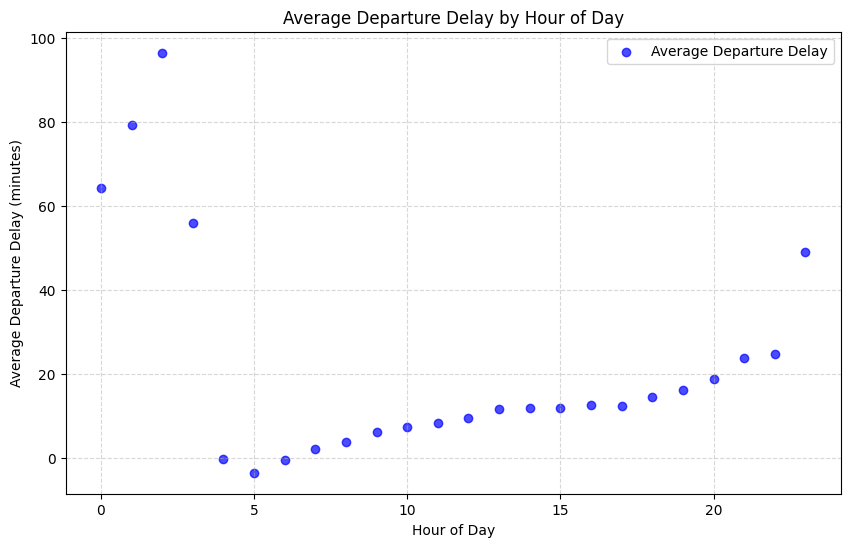

In [0]:
from pyspark.sql.functions import avg, hour, to_timestamp, lpad, col
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Filter out rows where DEP_TIME is null
flight_data = flight_data.filter(col('DEP_TIME').isNotNull())

# Convert DEP_TIME to a zero-padded string of length 4
flight_data = flight_data.withColumn('DEP_TIME_STR', lpad(col('DEP_TIME').cast('string'), 4, '0'))

# Convert the string time to a timestamp
flight_data = flight_data.withColumn('DEP_TIME_TS', to_timestamp(flight_data.DEP_TIME_STR, 'HHmm'))

# Extract hours from the timestamps
flight_data = flight_data.withColumn('DEP_HOUR', hour(flight_data.DEP_TIME_TS))

# Calculate average departure delay by hour
avg_delays_by_hour = flight_data.groupBy('DEP_HOUR').agg(
    avg('DEP_DELAY').alias('avg_dep_delay')
)

avg_delays_by_hour = avg_delays_by_hour.orderBy('DEP_HOUR')

# Display the resulting DataFrame
avg_delays_by_hour.show()




# Extract data for plotting
hours = avg_delays_by_hour.select('DEP_HOUR').collect()
avg_delay = avg_delays_by_hour.select('avg_dep_delay').collect()

# Create the scatter plot with customized style
plt.figure(figsize=(10, 6))
plt.scatter(hours, avg_delay, color='blue', label='Average Departure Delay', marker='o', alpha=0.7)
plt.title('Average Departure Delay by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines with dashed style and lower opacity

# Show the plot
plt.show()

